In [1]:
%matplotlib inline

In [2]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from gammapy.irf import load_cta_irfs
from gammapy.maps import WcsGeom, MapAxis
from gammapy.modeling.models import PowerLawSpectralModel
from gammapy.modeling.models import GaussianSpatialModel
from gammapy.modeling.models import SkyModel
from gammapy.cube import MapDataset, MapDatasetMaker, SafeMaskMaker
from gammapy.modeling import Fit
from gammapy.data import Observation
import os

In [3]:
!gammapy info --no-envvar --no-dependencies --no-system


Gammapy package:

	version                : 0.15       
	path                   : /home/rishank/anaconda2/envs/gammapy-0.12/lib/python3.6/site-packages/gammapy 



In [4]:
os.environ['CALDB'] = '/home/rishank/anaconda2/envs/cta/share/caldb/'
!echo $CALDB
!ls $CALDB

/home/rishank/anaconda2/envs/cta/share/caldb/
data


In [5]:
# Load the IRFs
# In this simulation, we use the CTA-1DC irfs shipped with gammapy.
irfs = load_cta_irfs(
    "$CALDB/data/cta/prod3b-v2/bcf/South_z20_50h/irf_file.fits"
)

In [6]:
# Define the observation parameters (typically the observation duration and the pointing position):
livetime = 24 * u.hr
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")

In [7]:
energy_reco = MapAxis.from_edges(
    np.logspace(-1.0, 1.0, 10), unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(0, 0), binsz=0.02, width=(6, 6), coordsys="GAL", axes=[energy_reco]
)
# It is usually useful to have a separate binning for the true energy axis
energy_true = MapAxis.from_edges(
    np.logspace(-1.5, 1.5, 30), unit="TeV", name="energy", interp="log"
)

In [8]:
# Define sky model to used simulate the data.
# Here we use a Gaussian spatial model and a Power Law spectral model.
spatial_model = GaussianSpatialModel(
    lon_0="0.2 deg", lat_0="0.1 deg", sigma="0.3 deg", frame="galactic"
)
spectral_model = PowerLawSpectralModel(
    index=2.2, amplitude="1.289e-12 cm-2 s-1 TeV-1", reference="1 TeV"
)
model_simu = SkyModel(
    spatial_model=spatial_model,
    spectral_model=spectral_model,
    name="model_simu",
)
print(model_simu)

SkyModel

   name     value   error      unit         min        max    frozen
--------- --------- ----- -------------- ---------- --------- ------
    lon_0 2.000e-01   nan            deg        nan       nan  False
    lat_0 1.000e-01   nan            deg -9.000e+01 9.000e+01  False
    sigma 3.000e-01   nan            deg  0.000e+00       nan  False
        e 0.000e+00   nan                 0.000e+00 1.000e+00   True
      phi 0.000e+00   nan            deg        nan       nan   True
    index 2.200e+00   nan                       nan       nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1        nan       nan  False
reference 1.000e+00   nan            TeV        nan       nan   True


In [9]:
# Create an in-memory observation
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)
# Make the MapDataset
empty = MapDataset.create(geom)
maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])
maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=4.0 * u.deg)
dataset = maker.run(empty, obs)
dataset = maker_safe_mask.run(dataset, obs)
print(dataset)

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 86400.0 s



MapDataset

    Name                            : obs_1 

    Total counts                    : nan 
    Total predicted counts          : 1969861.29
    Total background counts         : 1969861.29

    Exposure min                    : 7.88e+08 m2 s
    Exposure max                    : 3.13e+11 m2 s

    Number of total bins            : 0 
    Number of fit bins              : 804492 

    Fit statistic type              : cash
    Fit statistic value (-2 log(L)) : nan

    Number of models                : 1 
    Number of parameters            : 3
    Number of free parameters       : 1

    Component 0: 
        Name                        : background
        Type                        : BackgroundModel
        Parameters:
            norm                    : 1.000  
            tilt         (frozen)   : 0.000  
            reference    (frozen)   : 1.000  TeV




In [10]:
# Add the model on the dataset and Poission fluctuate
dataset.models = model_simu
dataset.fake()
# Do a print on the dataset - there is now a counts maps
print(dataset)

MapDataset

    Name                            : obs_1 

    Total counts                    : 1974800 
    Total predicted counts          : 1975232.43
    Total background counts         : 1969861.29

    Exposure min                    : 7.88e+08 m2 s
    Exposure max                    : 3.13e+11 m2 s

    Number of total bins            : 810000 
    Number of fit bins              : 804492 

    Fit statistic type              : cash
    Fit statistic value (-2 log(L)) : -3092127.55

    Number of models                : 2 
    Number of parameters            : 11
    Number of free parameters       : 6

    Component 0: 
        Name                        : model_simu
        Type                        : SkyModel
        Spatial  model type         : GaussianSpatialModel
        Spectral model type         : PowerLawSpectralModel
        Parameters:
            lon_0                   : 0.200  deg
            lat_0                   : 0.100  deg
            sigma             

In [11]:
# To plot, eg, counts:
dataset.counts.smooth(0.05 * u.deg).plot_interactive(
    add_cbar=True, stretch="linear"
)

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

In [12]:
# Make a copy of the dataset
dataset1 = dataset.copy()

In [19]:

# Define sky model to fit the data
spatial_model1 = GaussianSpatialModel(
    lon_0="0.1 deg", lat_0="0.1 deg", sigma="0.5 deg", frame="galactic"
)
spectral_model1 = PowerLawSpectralModel(
    index=2, amplitude="1e-12 cm-2 s-1 TeV-1", reference="1 TeV"
)
model_fit = SkyModel(
    spatial_model=spatial_model1,
    spectral_model=spectral_model1,
    name="model_fit",
)

dataset1.models = model_fit
print(model_fit)

SkyModel

   name     value   error      unit         min        max    frozen
--------- --------- ----- -------------- ---------- --------- ------
    lon_0 1.000e-01   nan            deg        nan       nan  False
    lat_0 1.000e-01   nan            deg -9.000e+01 9.000e+01  False
    sigma 5.000e-01   nan            deg  0.000e+00       nan  False
        e 0.000e+00   nan                 0.000e+00 1.000e+00   True
      phi 0.000e+00   nan            deg        nan       nan   True
    index 2.000e+00   nan                       nan       nan  False
amplitude 1.000e-12   nan cm-2 s-1 TeV-1        nan       nan  False
reference 1.000e+00   nan            TeV        nan       nan   True


In [20]:
# We do not want to fit the background in this case, so we will freeze the parameters
background_model = dataset1.background_model
background_model.parameters["norm"].value = 1.0
background_model.parameters["norm"].frozen = True
background_model.parameters["tilt"].frozen = True

print(background_model)

BackgroundModel

   name     value   error unit    min    max frozen
--------- --------- ----- ---- --------- --- ------
     norm 1.000e+00   nan      0.000e+00 nan   True
     tilt 0.000e+00   nan            nan nan   True
reference 1.000e+00   nan  TeV       nan nan   True


In [21]:
%%time
fit = Fit([dataset1])
result = fit.run(optimize_opts={"print_level": 1})

------------------------------------------------------------------
| FCN = -3.092E+06              |     Ncalls=159 (159 total)     |
| EDM = 0.000613 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
CPU times: user 22 s, sys: 27.5 ms, total: 22.1 s
Wall time: 22.1 s


(<matplotlib.axes._subplots.WCSAxesSubplot at 0x7f7068495128>, None)

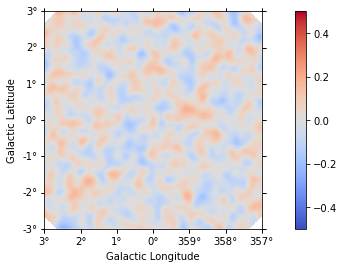

In [22]:
dataset1.plot_residuals(method="diff/sqrt(model)", vmin=-0.5, vmax=0.5)

In [23]:
print("True model: \n", model_simu, "\n\n Fitted model: \n", model_fit)

True model: 
 SkyModel

   name     value   error      unit         min        max    frozen
--------- --------- ----- -------------- ---------- --------- ------
    lon_0 2.000e-01   nan            deg        nan       nan  False
    lat_0 1.000e-01   nan            deg -9.000e+01 9.000e+01  False
    sigma 3.000e-01   nan            deg  0.000e+00       nan  False
        e 0.000e+00   nan                 0.000e+00 1.000e+00   True
      phi 0.000e+00   nan            deg        nan       nan   True
    index 2.200e+00   nan                       nan       nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1        nan       nan  False
reference 1.000e+00   nan            TeV        nan       nan   True 

 Fitted model: 
 SkyModel

   name     value   error      unit         min        max    frozen
--------- --------- ----- -------------- ---------- --------- ------
    lon_0 2.284e-01   nan            deg        nan       nan  False
    lat_0 8.312e-02   nan            deg -9.000e+0

In [24]:
result.parameters.to_table()

name,value,error,unit,min,max,frozen
str9,float64,float64,str14,float64,float64,bool
lon_0,2.284e-01,1.537e-02,deg,nan,nan,False
lat_0,8.312e-02,1.514e-02,deg,-9.000e+01,9.000e+01,False
sigma,3.026e-01,1.062e-02,deg,0.000e+00,nan,False
e,0.000e+00,0.000e+00,,0.000e+00,1.000e+00,True
phi,0.000e+00,0.000e+00,deg,nan,nan,True
index,2.185e+00,3.372e-02,,nan,nan,False
amplitude,1.255e-12,6.200e-14,cm-2 s-1 TeV-1,nan,nan,False
reference,1.000e+00,0.000e+00,TeV,nan,nan,True
norm,1.000e+00,0.000e+00,,0.000e+00,nan,True
